In [85]:
from Non_Maximum_Supression import non_maxi_supression
from Sliding_Window import sliding_window
from Pyramid import image_pyramid
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import img_to_array
from keras.applications import imagenet_utils
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [86]:
#ilklendirme parametreleri

WIDTH = 600
HEIGHT = 600
PYR_SCALE = 1.5
WIN_STEP = 16
ROI_SIZE = (200,150)
INPUT_SIZE = (224,224)

print("Resnet Yükleniyor")
model = ResNet50(weights="imagenet" , include_top = True)



Resnet Yükleniyor


(<Figure size 432x288 with 1 Axes>,
 <matplotlib.image.AxesImage at 0x285c33245b0>)

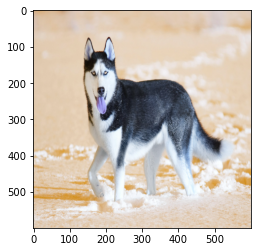

In [87]:
orig = cv2.imread("husky.jpg",1)
orig = cv2.resize(orig,dsize = (WIDTH,HEIGHT))
cv2.imshow("Husky",orig)
    
cv2.waitKey(0)
cv2.destroyAllWindows()

plt.figure(),plt.imshow(orig)


In [88]:
(H,W) = orig.shape[:2]

#image pyramid
pyramid = image_pyramid(orig,PYR_SCALE,ROI_SIZE)

In [89]:
rois = []
locs = []

In [90]:
for image in pyramid:
    
    scale = W/float(image.shape[1])
    
    for (x,y, roiOrig) in sliding_window(image,WIN_STEP,ROI_SIZE):
        x = int(x*scale)
        y = int(y*scale)
        w = int(ROI_SIZE[0]*scale)
        h = int(ROI_SIZE[1]*scale)
        
        roi = cv2.resize(roiOrig,INPUT_SIZE)
        roi = img_to_array(roi)
        roi = preprocess_input(roi)
        
        rois.append(roi)
        locs.append((x,y,x+w,y+h))
        
rois = np.array(rois, dtype = "float32")

print("Sınıflandırma İşlemi")
preds = model.predict(rois)
preds = imagenet_utils.decode_predictions(preds, top = 1)

Sınıflandırma İşlemi


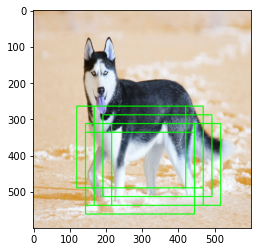

In [91]:
labels = {}
min_conf = 0.9

for (i,p) in enumerate(preds):
    (_,label,prob) = p[0]
    
    if prob >= min_conf:
        box = locs[i]
        
        L = labels.get(label,[]) # [] döndürüyor neden get yaptığını anlamadım
        L.append((box,prob))
        labels[label] = L
        
for label in labels.keys():
    clone = orig.copy()
    
    for (box,prob) in labels[label]:
        (startX,startY,endX,endY) = box
        cv2.rectangle(clone,(startX,startY),(endX,endY),(0,255,0),2)
    cv2.imshow("ilk",clone)
    plt.figure(),plt.imshow(clone)
    
cv2.waitKey(0)
cv2.destroyAllWindows()

In [92]:
#non-maxima
clone = orig.copy()
boxes = np.array([p[0] for p in labels[label]])
proba = np.array([p[1] for p in labels[label]])

boxes = non_maxi_supression(boxes,proba)

for (startX, startY, endX, endY) in boxes:
    cv2.rectangle(clone, (startX,startY),(endX,endY),(0,255,0),2)
    y = startY - 10 if startY - 10 > 10 else startY + 10
    cv2.putText(clone, label, (startX,y),cv2.FONT_HERSHEY_SIMPLEX,1.5,(0,255,0),6)
    


In [93]:
cv2.imshow("Maxima",clone)

cv2.waitKey(0)
cv2.destroyAllWindows()

(<Figure size 432x288 with 1 Axes>,
 (-0.5, 599.5, 599.5, -0.5))

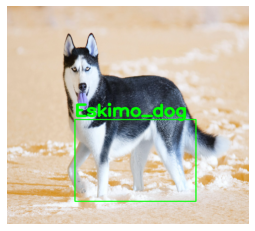

In [94]:
plt.figure(),plt.imshow(clone,aspect=0.9),plt.axis("off")